In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy as sy
import scipy.stats as ss
import scipy.signal
import pandas as pd
import PIL.Image
import os

import dynamics as dyn

from functions.plotting_tools import save_figures
from functions.plotting_tools import set_layout
from KDEpy import NaiveKDE
from KDEpy import FFTKDE

from scipy.signal import savgol_filter

### 1. Insert the path to find your cmaps. Your path HAS to be cmaps/< YOUR PROTEIN >/< YOUR RUN >

You can change the path if you edit manually protein and run name. Also, keep in the cmaps folder ONLY csv files from contact maps of the protein/run you want to analyze.

In [5]:
path_cmaps ='cmaps/gamma syn/run1'
protein= path_cmaps[6:15]
run = path_cmaps[16:len(path_cmaps)]
set_layout()
print('You are analyzing maps from {}, {}'.format(protein.upper(), run.upper()))

You are analyzing maps from GAMMA SYN, RUN1


READ CMAPS

In [55]:
files = os.listdir(path_cmaps)
files_csv = [f for f in files if f[-3:] == 'csv']
len_dataset=len(files_csv)
cmap= pd.read_csv('{}/{}'.format(path_cmaps, files_csv[0]), header=None)

len_map=cmap.shape[0]

print('Number of frames: {}'.format(len_dataset))

Number of frames: 1018


### 2. Write path for figures

In [57]:
path_figures= 'results/figures/{}/{}'.format(protein, run)
SAVE_FIG = True
set_layout()

### 3. Pick path for printing lifetime distribution 

In [10]:
path_distributions= 'results/distributions/{}/{}'.format(protein, run)
SAVE_DIST = False

PROCESS CMAPS, PLOT KYMOGRAPHS AND CALCULATE LIFETIME DISTRIBUTION

Fit parameters:
A = 0.38832967042684413, k = 0.5359829501942011


FileNotFoundError: [Errno 2] No such file or directory: 'results/distributions/gamma syn/run1/lifetime_gamma syn_run1.csv'

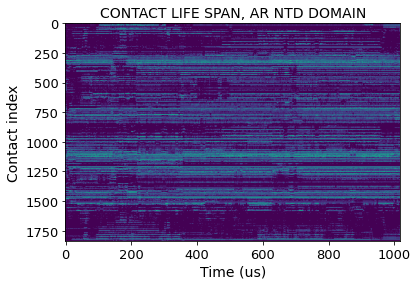

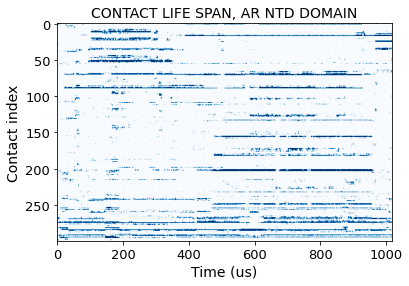

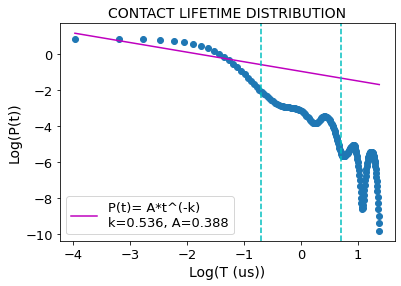

In [58]:
start=0
end=len_map
start_frame=0
start_fit=20

graph_cmap, dyn_cmap_flat=dyn.flatten_cmaps(start, end, start_frame, len_dataset,files_csv, path_cmaps)

#Plot kymograph
a = dyn.plot_kymograph(graph_cmap)
#plot kymograph detail:
b = dyn.plot_kymograph(graph_cmap[0:300, :], cmap=1)

#Calculate maximum lifetime per contact
max_dist, max_lifetime_array, lifetime_matrix=dyn.find_max_lifetime_perres(dyn_cmap_flat, len_dataset)
#Make contact lifetime distribution
x,y,fit_dist,optim,max_array= dyn.lifetime_distribution(max_dist, start_fit)

#Plot distribution with fit
c = dyn.log_plot(x,y,fit_dist,optim)


#Save results

if SAVE_DIST:
    dist={'Time': x, 'Lifetime distribution': y,'Fit distributions':fit_dist, 'Protein': protein, 'Run':run}
    dist_df=pd.DataFrame(dist)
    dist_df.to_csv('{}/lifetime_{}_{}.csv'.format(path_distributions, protein, run))
    
if SAVE_FIG:
    plots = [a,b,c]
    name_figures = ['kymo', 'kimo_detail', 'lifetime']
    for plot, name in zip(plots, name_figures):
        save_figures(plot, path_figures, name)


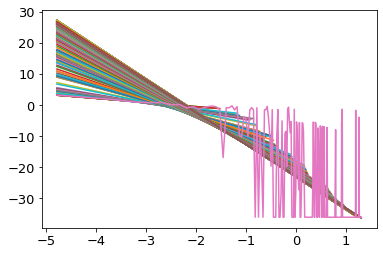

In [42]:
x_new, y_new = NaiveKDE(bw='ISJ').fit(max_dist*0.005).evaluate( grid_points= 260)


dist={'X': x_new, 'Y': y_new}
dist=pd.DataFrame(dist)


adjust = 0
dist_above_zero= dist[dist['X']>0]
dist_above_zero = dist_above_zero[adjust:]

log_x = np.array(np.log(dist_above_zero['X']))
log_y = np.array(np.log(dist_above_zero['Y']))


increment=1
start_point = 2
end_point = len(log_y) - np.mod(len(log_y), increment)

intervals=np.arange(start_point,end_point, increment)
r_squared=[]
time=[]


for interval in intervals:
    slope, intercept, r_value, p_value, std_err = ss.linregress(log_x[0:interval], log_y[0:interval])
    new_fit=intercept + slope*log_x[0:interval]
    r_squared.append(r_value**2)
    time.append(np.exp(log_x[interval]))
    plt.plot(log_x[0:interval], new_fit)
    
plt.plot(log_x[0:interval], log_y[0:interval])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


stamp 1 = 0.2336148648648649
stamp 2 = 1.2845608108108109


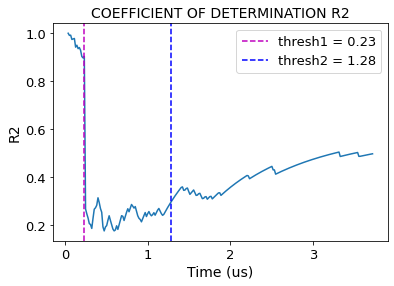

In [54]:
rsq = plt.figure()

plt.plot(time, r_squared)

rsquared_thresh1= 0.8
rsquared_thresh2= 0.3

name= 'r_squared_{}'.format(rsquared_thresh2)

short_stamp=1
middle_stamp=1
long_stamp = 1

for t in range(len(time)-1):
    if (r_squared[t] < rsquared_thresh1 and short_stamp):
        print('stamp 1 = {}'.format(time[t-1]))
        stamp1 = time[t-1]
        arg_stamp1=t-1
        short_stamp = 0
    if (r_squared[t] == np.min(r_squared) and middle_stamp):
        middle_stamp = 0
    if (r_squared[t] > rsquared_thresh2  and middle_stamp ==0 and long_stamp):
        print('stamp 2 = {}'.format(time[t-1]))
        long_stamp=0
        stamp2 = time[t-1]
        arg_stamp2=t-1

stamp1_label = round(stamp1, 2)
stamp2_label = round(stamp2, 2)

plt.axvline(stamp1_label, 0, 1.5, color='m', ls= '--', label = 'thresh1 = {}'.format(stamp1_label))
plt.axvline(stamp2_label, 0, 1.5, color='b', ls= '--', label = 'thresh2 = {}'.format(stamp2_label))
    
plt.title('COEFFICIENT OF DETERMINATION R2')    
plt.ylabel('R2')  
plt.xlabel('Time (us)')   
plt.legend()

save_figures(rsq, path_figures, name)

# PLOT DISTRIBUTION

Choose if you want to save the figure and if you want the fitting

In [44]:
arg_stamp1

13

In [48]:
save_fig_dist = True
plot_fit = True

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


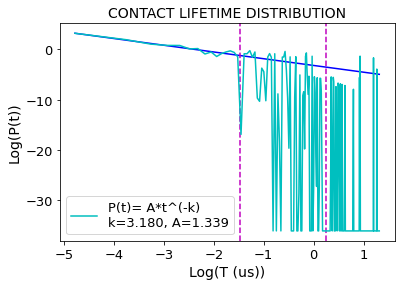

In [49]:
dist = plt.figure()
name = 'nongauss_dist_{}'.format(rsquared_thresh2)

slope, intercept, r_value, p_value, std_err = ss.linregress(log_x[0:arg_stamp1], log_y[0:arg_stamp1])
new_fit=intercept + slope*log_x

k="%.3f" % round(-intercept, 3)
A="%.3f" % round(-slope, 3)

plt.title('CONTACT LIFETIME DISTRIBUTION')

if plot_fit:
    plt.plot(log_x, new_fit, color = 'b')
    plt.axvline(np.log(stamp1_label), 0, 1.5, color='m', ls= '--')
    plt.axvline(np.log(stamp2_label), 0, 1.5, color='m', ls= '--')
    label_fit = 'P(t)= A*t^(-k)\nk={}, A={}'.format(k, A)
else:
    label_fit = 'Contact lifetime'

plt.plot(log_x, log_y, color='c', 
label= label_fit)
plt.xlabel('Log(T (us))')
plt.ylabel('Log(P(t))')
plt.legend()


if save_fig_dist:
    save_figures(dist, path_figures, name)

### 4. Pick path for masks (cmap lifetime filters)

split is the end residue of the first segment for division of the contact map. It is meant for division into 2 SEGMENTS. If you do not want to split the map, write split = False, or 0.

In [50]:
path_mask='results/dynamic masks/{}/{}'.format(protein, run)
split = False
SAVE_MASK= True


CALCULATE FILTERS FOR SHORT, MIDDLE AND LONG LIFE, TO APPLY ON CONTACT MAPS IN THE MAIN CT CODE

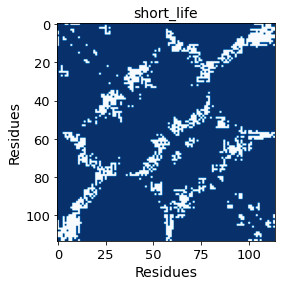

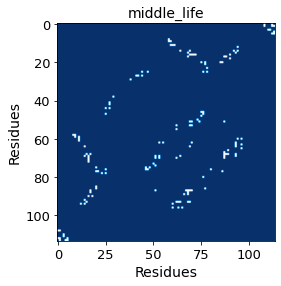

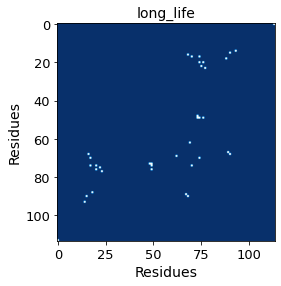

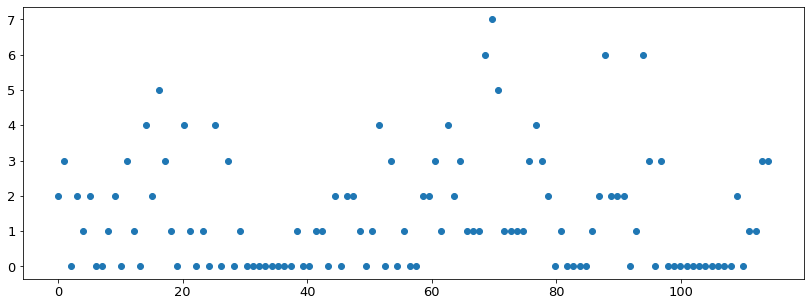

In [51]:
thresh=[stamp1_label,stamp2_label]

lifetime = ['short_life', 'middle_life', 'long_life']
shape = cmap.shape[0]

for life in lifetime:
    mask= dyn.create_mask(max_lifetime_array, life, thresh, shape, path_mask, split, SAVE_MASK)
    
    if (life == 'middle_life'):
        profile=np.sum(mask, axis = 1)
        
    plt.figure()
    plt.title(life)
    plt.imshow(np.log(mask + 1), 'Blues_r')
    plt.xlabel('Residues')
    plt.ylabel('Residues')
    plt.savefig('{}/{}_map.jpg'.format(path_mask, life))
    
plt.figure(figsize = (14, 5))
plt.scatter(np.linspace(0, mask.shape[0], mask.shape[1]), profile)
#plt.xlim(100, 160)
#plt.xtick

### 5. Pick path for saving C factor

In [52]:
path_cfactor= 'results/C_factor/{}/{}'.format(protein, run)
SAVE_DIST = True

CALCULATE AVERAGE CONTACT DURATION PER RESIDUE (C-FACTOR) AND MAXIMUM CONTACT DURATION PER RESIDUE (C*-FACTOR)

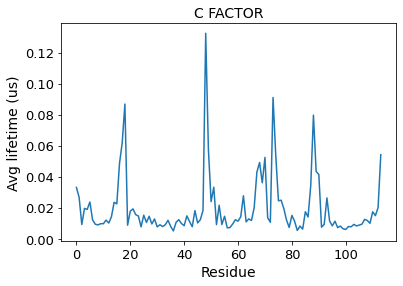

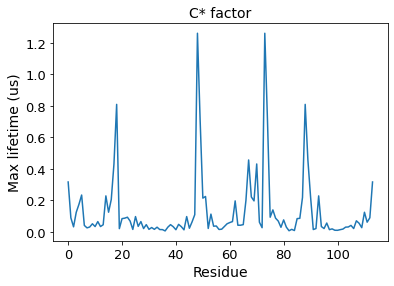

In [53]:
#Calculate all lifetimes for all existing contact in the MD run
all_lifetimes = dyn.compute_lifetime(max_lifetime_array,lifetime_matrix)
#Calculate average and max contact life per residue
avg_perres, max_perres = dyn.avg_lifetime_perres(all_lifetimes, max_lifetime_array, lifetime_matrix,
                                             cmap.shape[1])
#Plot C and C* factor
plot1, plot2 = dyn.plot_Cfactors(avg_perres, max_perres, path_figures, SAVE_DIST)
#Save C and C* factor to csv for further analysis
dyn.save_cfactor(avg_perres, max_perres, path_cfactor)

PLOT SPACE CONTACT RANGE (IN NUMBER OF RESIDUES)

In [27]:
mode='weighted'
#Calculates the res-res range for spatial contacts. Three outputs: the average, max and weighted average contact range
ranges= dyn.avg_contact_range(all_lifetimes, max_lifetime_array, lifetime_matrix, cmap.shape[0])
#Plot the distribution of contact range for chosen mode
plot= dyn.plot_contact_range(ranges, path_figures, mode, SAVE_FIG)
#Calculate the threshold for long range contacts
long_range_threshold= dyn.calculate_threshold(ranges, mode)

C:\Users\scalvinib\Anaconda3\envs\data_analysis\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\scalvinib\Anaconda3\envs\data_analysis\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: zero-size array to reduction operation maximum which has no identity